In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import time
import glob
import datetime
from datetime import datetime, timedelta


In [27]:
start = time.time()
data_by_year = {}

for year in range(2021, 2022):
    month_limit = datetime.now().month + 1 if year == 113 else 13
    
    for date in tqdm(range(1, 367), desc=f'{year}'):
        try:
            url = f'https://www.twse.com.tw/rwd/zh/block/BFIAUU?date={year}01{date}&selectType=S&response=json'
            res = requests.get(url)
            res.raise_for_status()
            data = res.json().get('data', [])
            da = res.json()['title'].replace("年", "-").replace("月", "-")[:9]
            year = str(int(da[:3]) + 1911)
            da = year + da[3:]
            
            if not data:
                continue
            data = [i + [da] for i in data]
            
            if year not in data_by_year:
                data_by_year[year] = []
            
            data_by_year[year].extend(data[:-1])
        except Exception as e:
            continue

    for year, data in data_by_year.items():
        df = pd.DataFrame(data)
        
        df[3] = df[3].str.replace(',', '')
        df[3] = df[3].apply(lambda x: float(x) if x != '' else 0.0)
        df[4] = df[4].str.replace(',', '').astype(float)
        df[5] = df[5].str.replace(',', '').astype(float)
        df[6] = pd.to_datetime(df[6], format='%Y-%m-%d') 
        
        df.columns = ['證券代號', '證券名稱', '交易類別', '成交價格', '成交股數', '成交金額', '日期']
        filename = f'stock_data_{year}.parquet'
        df.to_parquet(filename, engine='pyarrow')
        print(f"Data for year {year} saved to {filename}")

2021: 100%|██████████| 366/366 [00:59<00:00,  6.17it/s]


Data for year 2021 saved to stock_data_2021.parquet
   證券代號   證券名稱  交易類別    成交價格       成交股數          成交金額         日期
0  6230  尼得科超眾  逐筆交易  212.50  6883410.0  1.462725e+09 2021-01-04
1  2330    台積電  配對交易  539.50    80000.0  4.316000e+07 2021-01-04
2  2330    台積電  配對交易  537.50   100000.0  5.375000e+07 2021-01-04
3  2892    第一金  配對交易   21.22   500000.0  1.061000e+07 2021-01-04
4  2913     農林  配對交易   18.40   600000.0  1.104000e+07 2021-01-04


In [47]:
import os
list_ = [fname for fname in os.listdir() if fname.endswith("parquet")]
print(list_)
list_df = []
for fname in list_:
    list_df.append(pd.read_parquet(fname))
final_df = pd.concat(list_df)
group_data = []
rolling = 365
for group_name, group_df in tqdm(final_df.groupby('證券代號'), desc='loop by symbol'):
    if group_name == "總計":continue
    if len(group_name) != 4: continue
    group_df.sort_values(by='日期', ascending=True, inplace=True)
    group_df['年均價'] = 0.0
    for last_date in group_df['日期']:
        start_date = last_date - timedelta(days=rolling)
        time_df = group_df[(group_df['日期'] >= start_date) & (group_df['日期'] <= last_date)]
        total_amount = time_df['成交金額'].sum()
        total_volume = time_df['成交股數'].sum()
        avg_price = total_amount/total_volume
        
        group_df.loc[group_df['日期'] == last_date, '年均價'] = avg_price
    group_data.append(group_df)
df = pd.concat(group_data)
df_drop = df.dropna(axis=1)

loop by symbol:   0%|          | 0/582 [00:00<?, ?it/s]

loop by symbol: 100%|██████████| 582/582 [00:14<00:00, 39.76it/s] 


In [56]:
list_ = []
for year in range(2024, 2018, -1):
    for stock_code in tqdm(set(df['證券代號']), desc=f"{year}"):
        month_limit = datetime.now().month + 1 if year == 2024 else 13
        for month in range(1, month_limit):
            mo = f"0{month}" if month < 10 else month
            try:
                url = f'https://www.twse.com.tw/rwd/zh/afterTrading/STOCK_DAY_AVG?date={year}{mo}01&stockNo={stock_code}&response=json'
                res = requests.get(url)
                res.raise_for_status()
                json_data = res.json()
                data = json_data.get('data', [])

                if not data:
                    continue

                data = [row for row in data if not row[0].startswith('月平均')]
                data = [i + [stock_code] for i in data]
                list_.append(data)

            except Exception as e:
                print(f"Error: {e}")
        list_df = [pd.DataFrame(i) for i in list_]
    final_df = pd.concat(list_df)
final_df.columns = ['da', 'cl', 'code']

def _(x):
    year, mo, date = x.split("/")
    return f"{int(year)+1911}-{mo}-{date}"
final_df['date'] = final_df['da'].apply(_)

final_df['cl'] = final_df['cl'].apply(lambda x: str(x).replace(",", ""))
final_df['cl'] = final_df['cl'].apply(lambda x: 0.0 if x == "--" else x)
final_df['cl'] = final_df['cl'].astype(float)

df_drop_duplicate = final_df.drop_duplicates(subset=['code', 'date'])
pivoted_cl = df_drop_duplicate.pivot(values='cl', columns='code', index='date')
pivoted_cl.sort_index(ascending=True, inplace=True)

2019: 100%|██████████| 535/535 [18:01<00:00,  2.02s/it]


In [58]:
pivoted_cl.to_parquet("cl_s2019.parquet")

## Start from df_drop and pivoted_cl

In [153]:
pivoted_cl.index = pd.to_datetime(pivoted_cl.index)
pivoted_cl.to_parquet("cl_2019.parquet")

In [154]:
# add close price
block_trade = df_drop.copy()
block_trade['cl'] = None
def block_trade_cl(row):
    code, da = row['證券代號'], row['日期']
    return pivoted_cl[code][da]
block_trade['cl'] = block_trade.apply(block_trade_cl, axis=1)

In [241]:
# create signal
block_trade_sortda = block_trade.sort_values(by='日期', ascending=True)
def calc_factor(row):
    avg, cl = row['年均價'], row['cl']
    try:
        diff = avg/cl - 1
        # if diff > 0.3: print(avg, cl, row['日期'], row['證券代號'])
        return diff if diff < -0.3 else 0.0
    except ZeroDivisionError as e:
        return 0.0
concat_list = []
for enum, (i, j) in enumerate(block_trade_sortda.groupby('日期')):
    j.drop_duplicates(subset=['證券代號', '證券名稱'], inplace=True)
    j['factor'] = j.apply(calc_factor, axis=1)
    concat_list.append(j)
concated_pd = pd.concat(concat_list)
concated_pd

,證券代號,證券名稱,交易類別,成交價格,成交股數,成交金額,日期,年均價,cl,factor
0,6230,尼得科超眾,逐筆交易,212.50,6883410.0,1.462725e+09,2021-01-04,212.500000,214.00,0.0
2,2330,台積電,配對交易,537.50,100000.0,5.375000e+07,2021-01-04,538.388889,536.00,0.0
4,2913,農林,配對交易,18.40,600000.0,1.104000e+07,2021-01-04,18.400000,18.20,0.0
3,2892,第一金,配對交易,21.22,500000.0,1.061000e+07,2021-01-04,21.220000,21.10,0.0
5,3037,欣興,配對交易,91.15,200000.0,1.823000e+07,2021-01-04,91.150000,90.50,0.0
...,...,...,...,...,...,...,...,...,...,...
4636,1454,台富,配對交易,20.00,12000000.0,2.400000e+08,2024-08-07,19.846154,19.05,0.0
4663,3665,貿聯-KY,配對交易,371.50,232255.0,8.628273e+07,2024-08-07,320.981114,371.50,0.0
4662,3661,世芯-KY,配對交易,2024.14,14025.0,2.838856e+07,2024-08-07,3413.380752,2175.00,0.0
4642,2327,國巨,配對交易,702.00,118814.0,8.340743e+07,2024-08-07,590.400415,702.00,0.0


In [242]:
def plot_backtest(cl_2330, j):
    cl_2330 = pivoted_cl[[i]].copy().loc['2021-01-01':]
    cl_2330['signal'] = None
    for da in j[j['factor'] != 0.0]['日期']:
        cl_2330.loc[da, 'signal'] = 1
    cl_2330['ma20'] = cl_2330[i].rolling(20).mean()
    cl_2330['ma60'] = cl_2330[i].rolling(60).mean()
    plt.plot(cl_2330[i])
    plt.plot(cl_2330["ma20"])
    plt.plot(cl_2330["ma60"])
    plt.plot(j['日期'], j['年均價'])
    for da in j[j['factor'] != 0.0]['日期']:
        plt.axvline(x=da, color='red', linestyle='--', label='Signal')
    plt.title(i)
    plt.show()

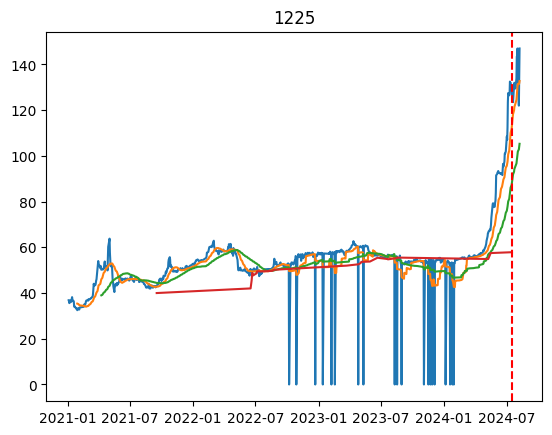

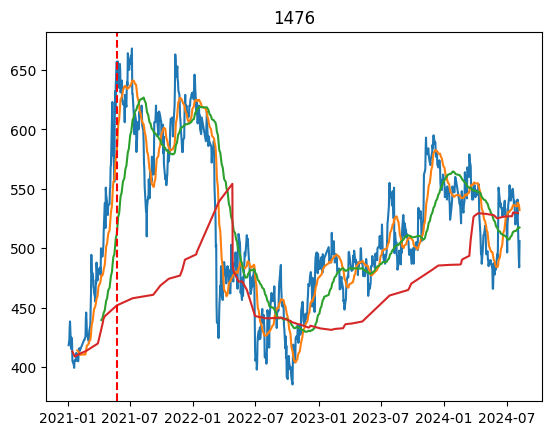

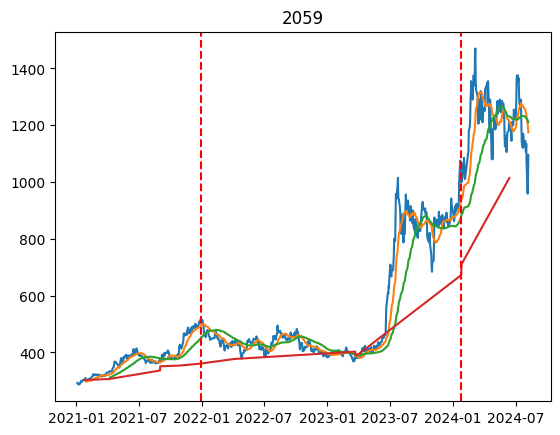

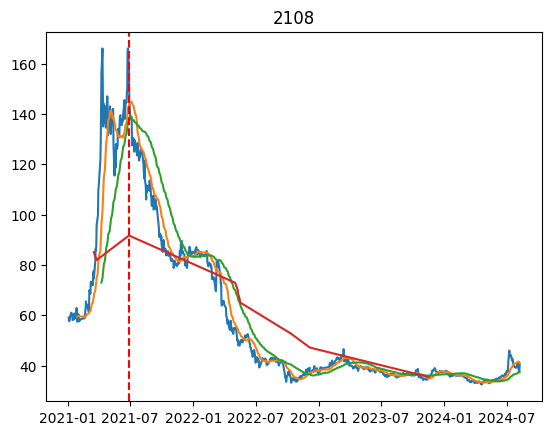

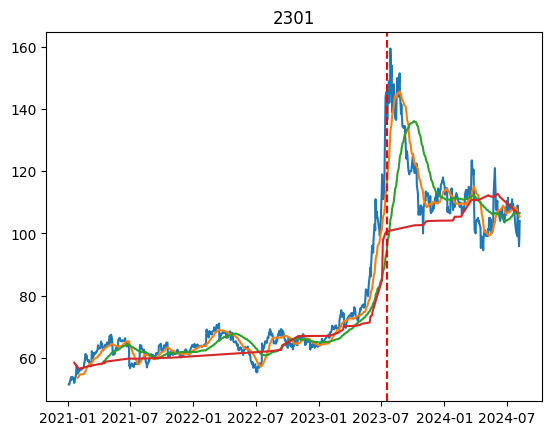

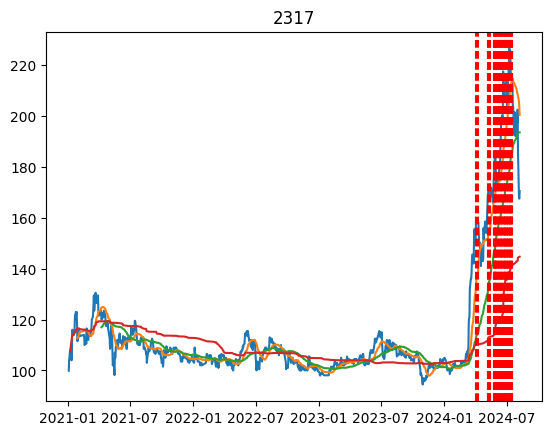

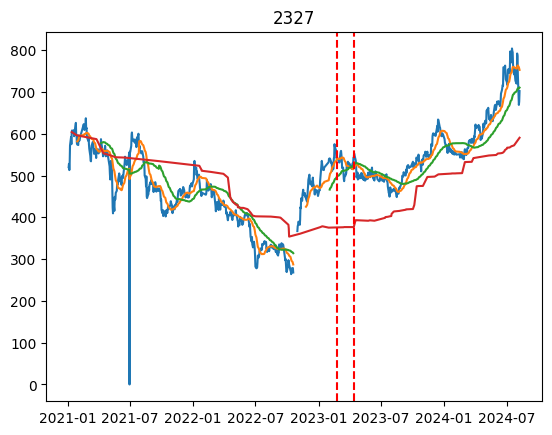

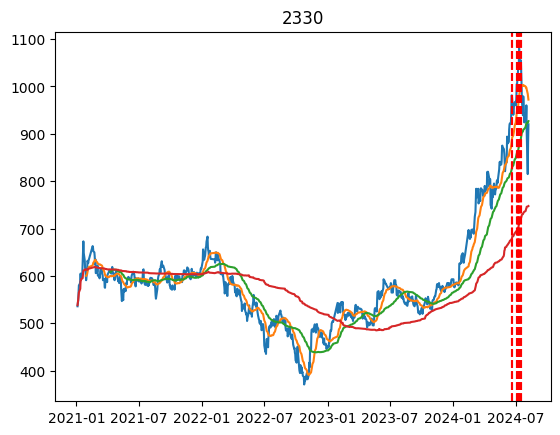

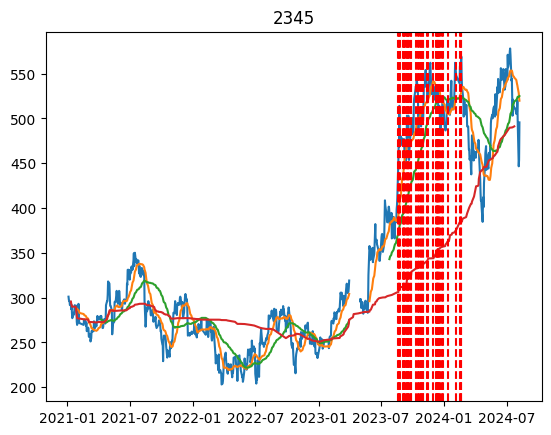

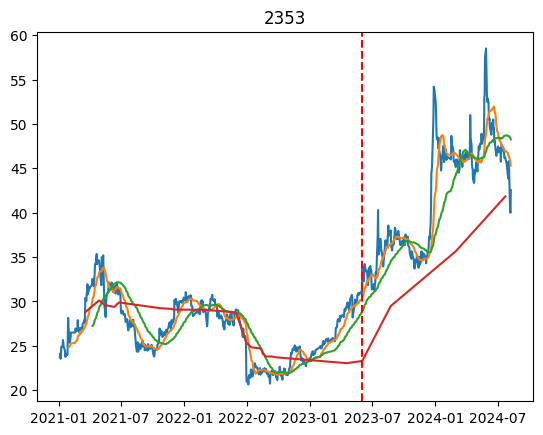

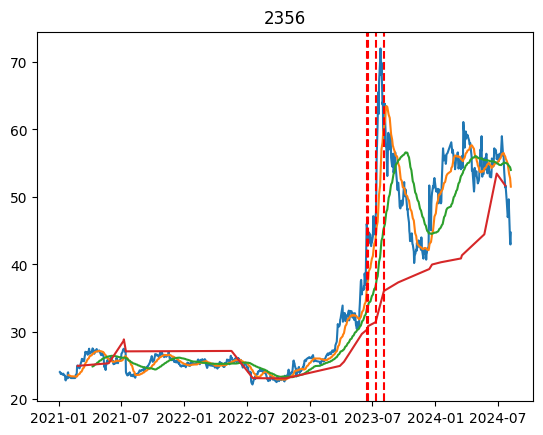

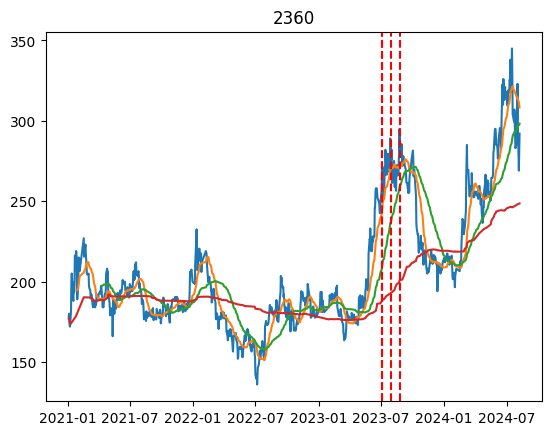

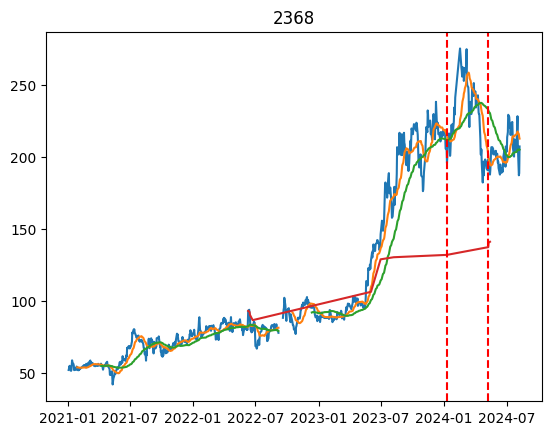

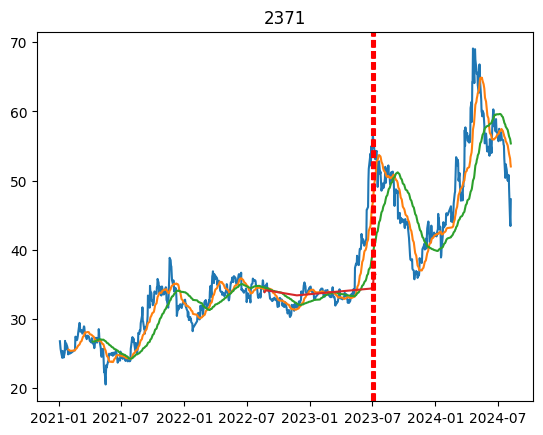

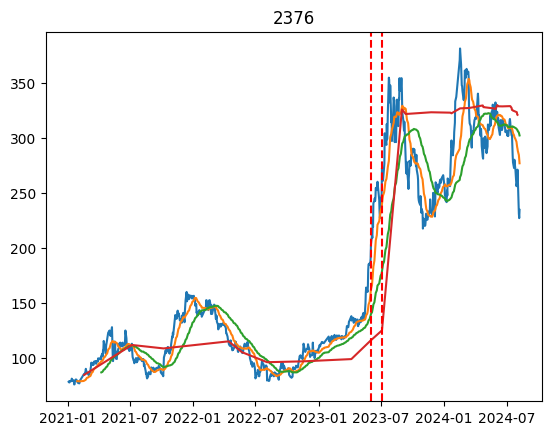

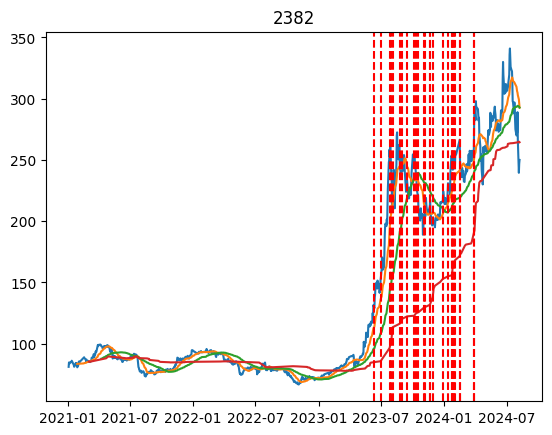

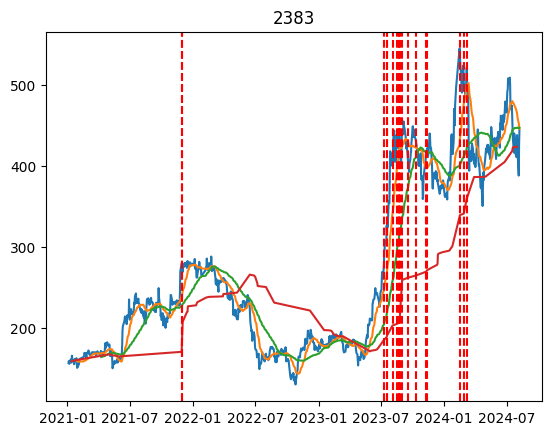

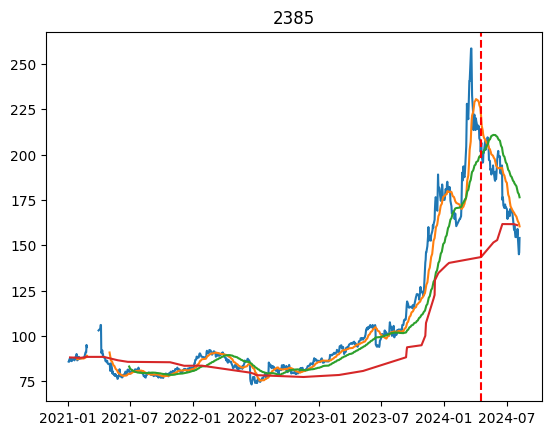

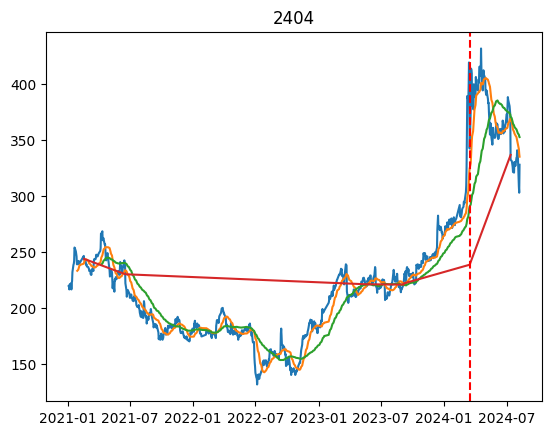

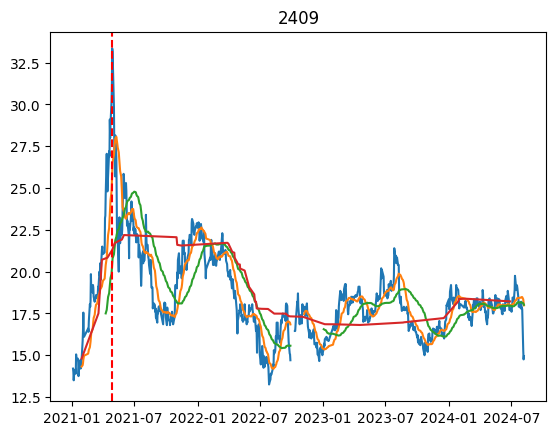

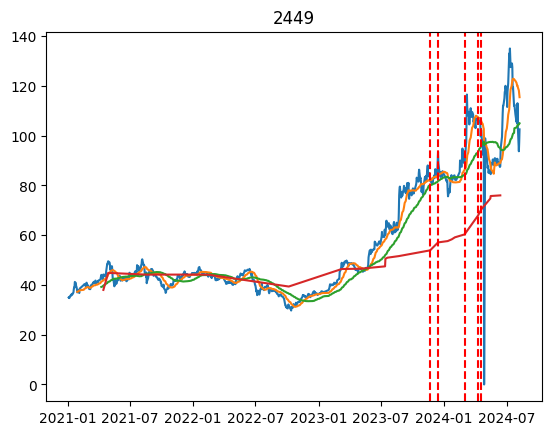

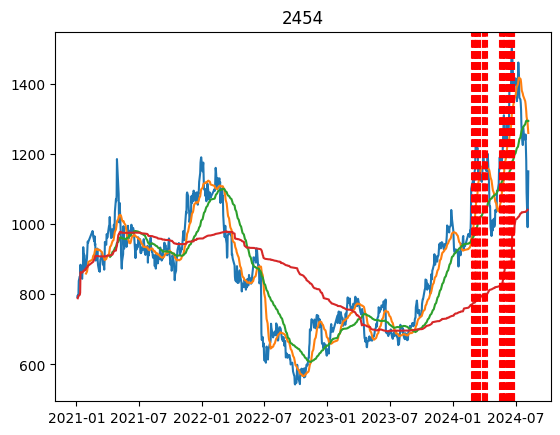

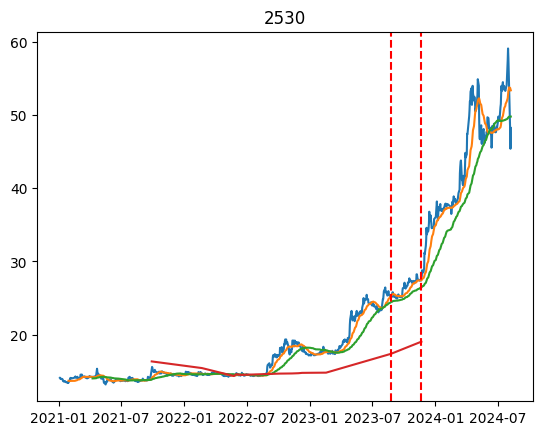

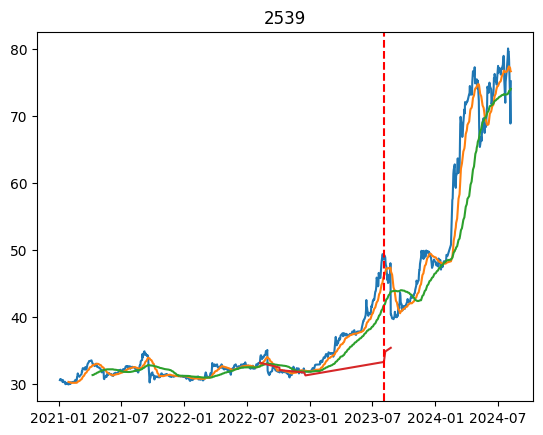

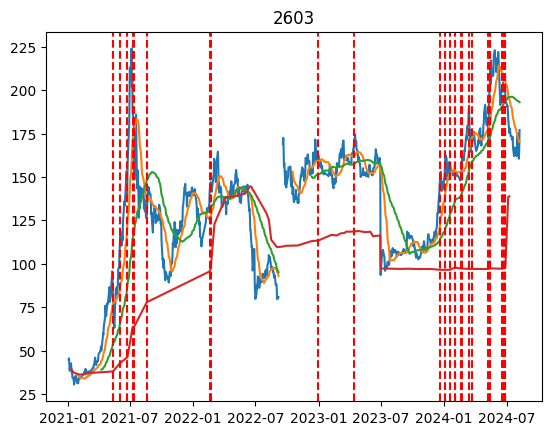

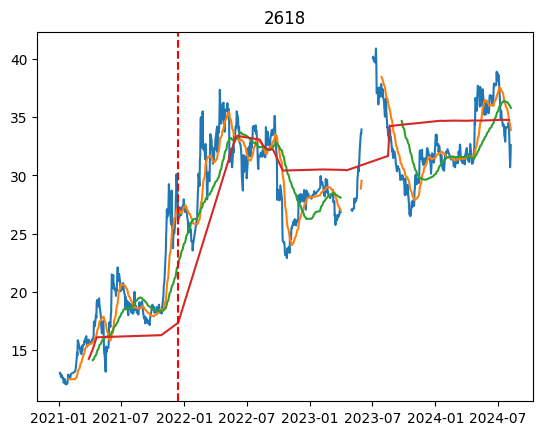

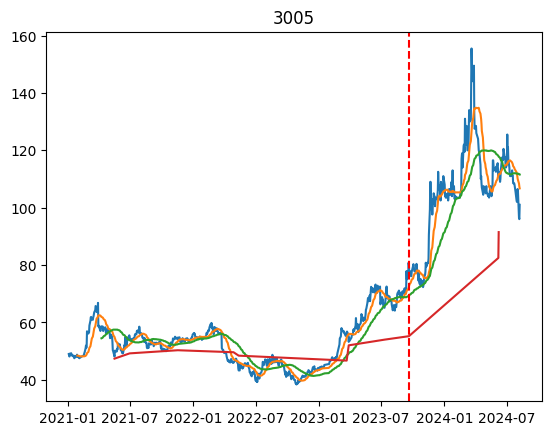

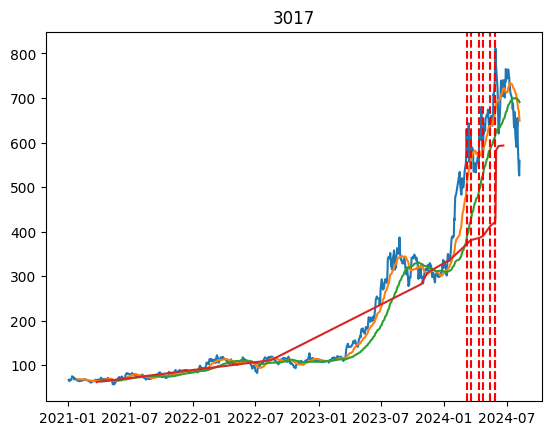

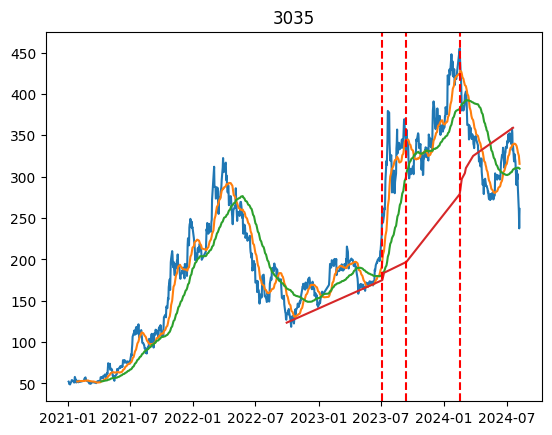

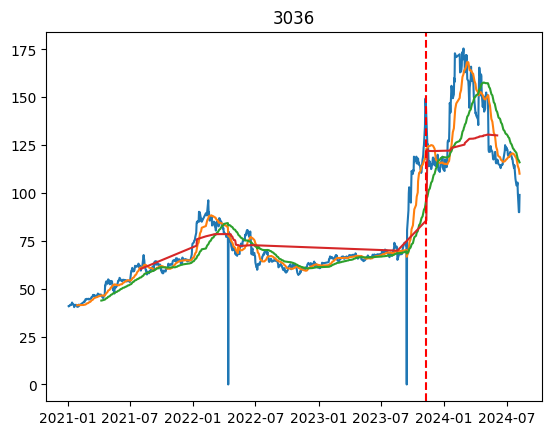

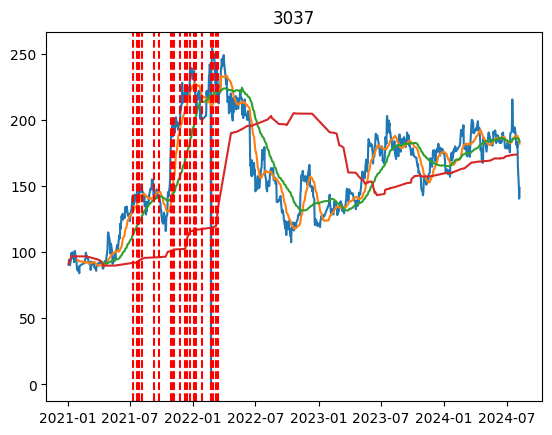

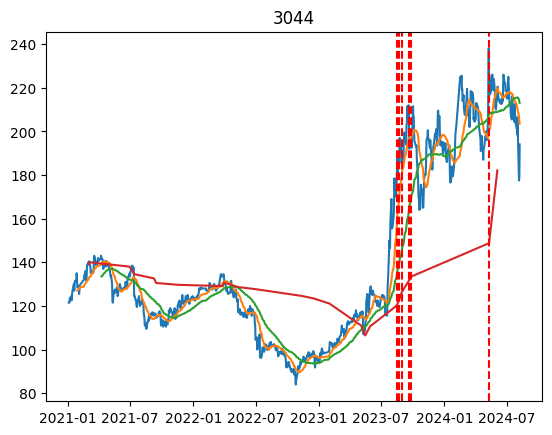

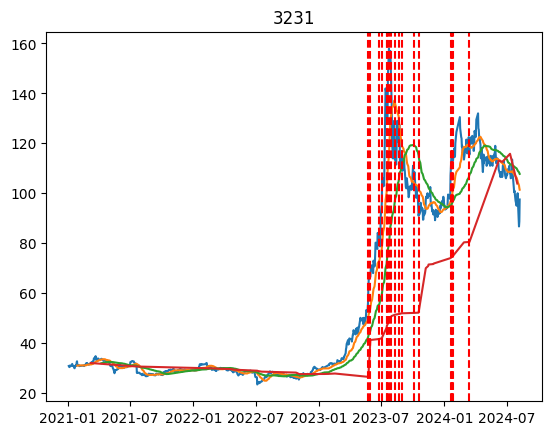

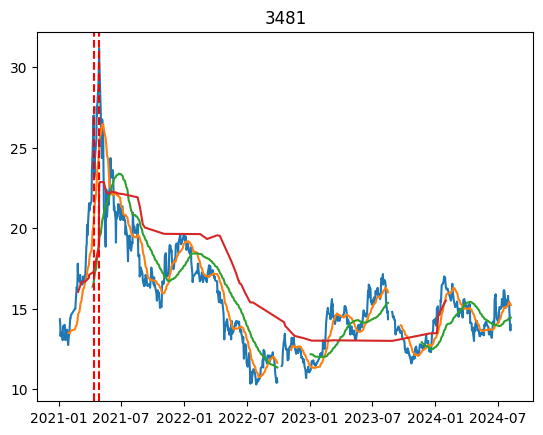

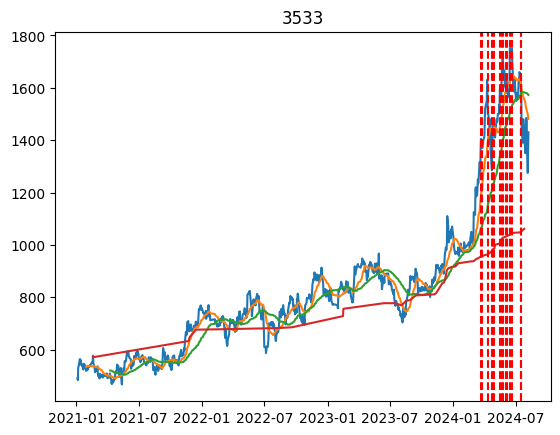

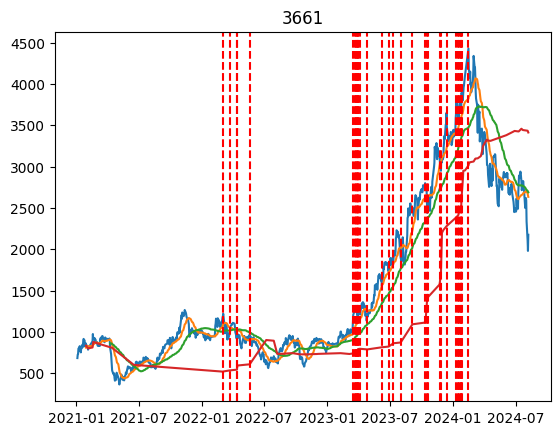

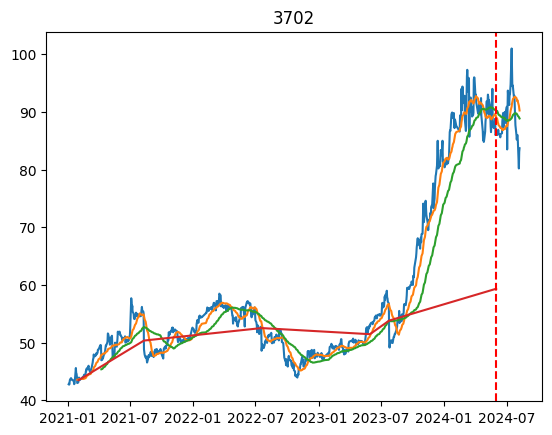

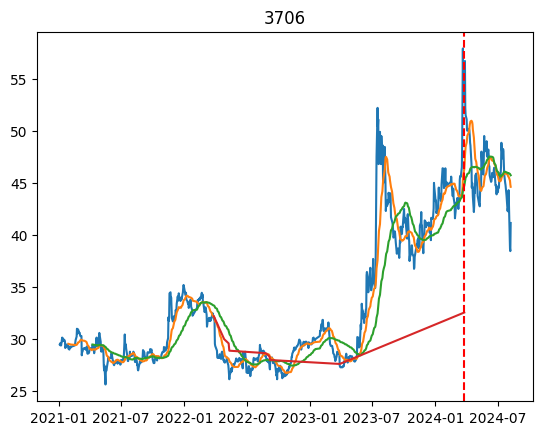

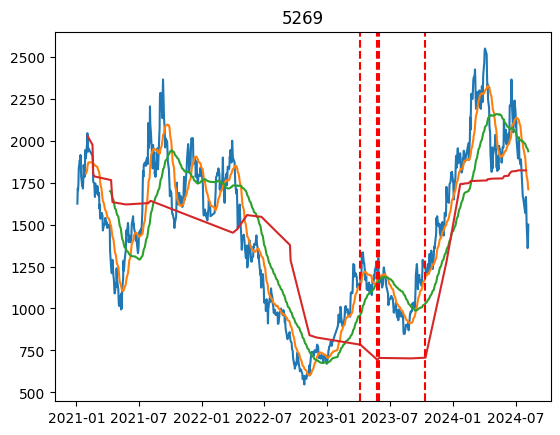

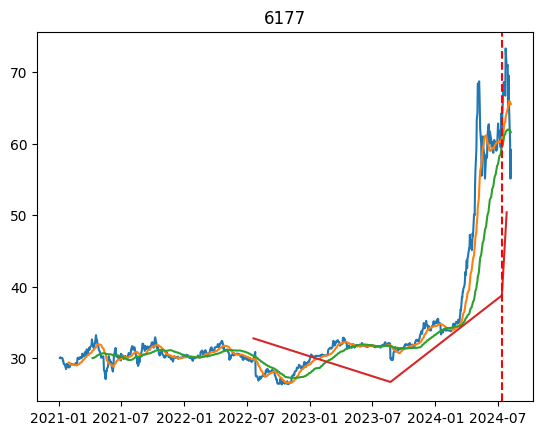

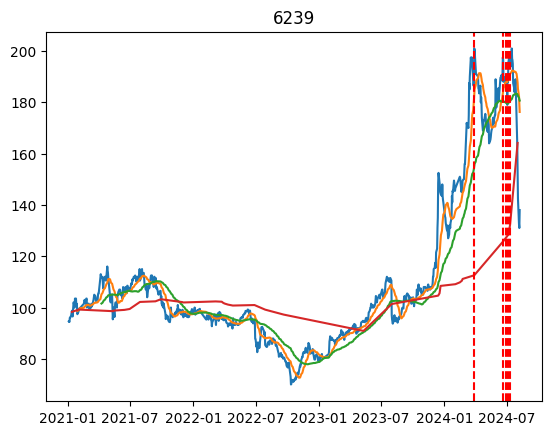

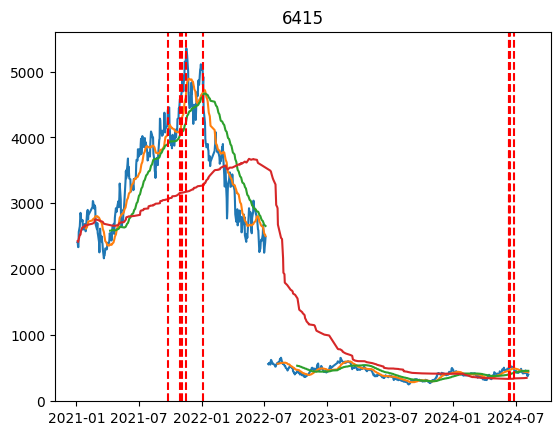

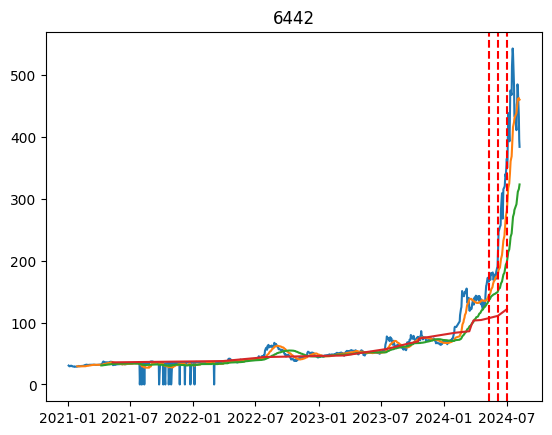

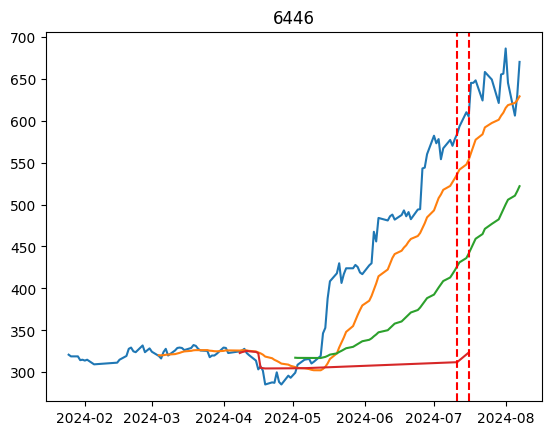

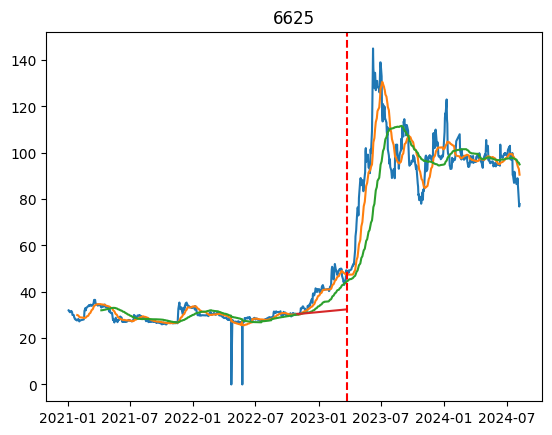

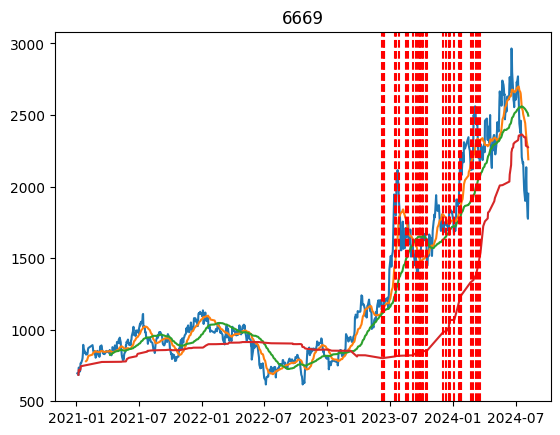

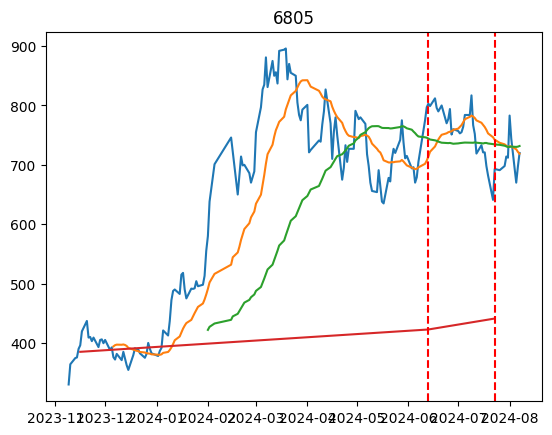

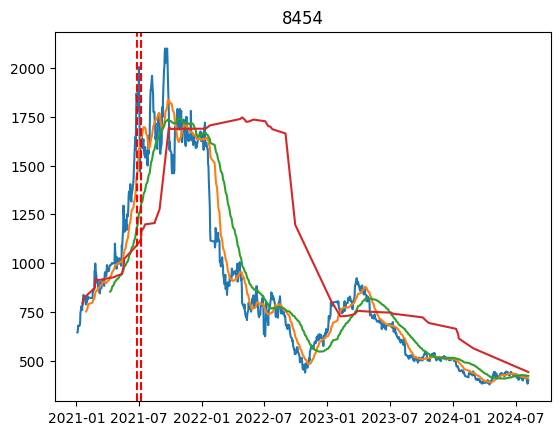

In [243]:
for enum, (i, j) in enumerate(concated_pd.groupby('證券代號')):
    if len(j[j['factor'] != 0.0]['日期'].values) == 0:
        continue
    plot_backtest(cl_2330, j)

In [206]:
da[0]

Timestamp('2024-08-07 00:00:00')

Text(0.5, 1.0, '2330')

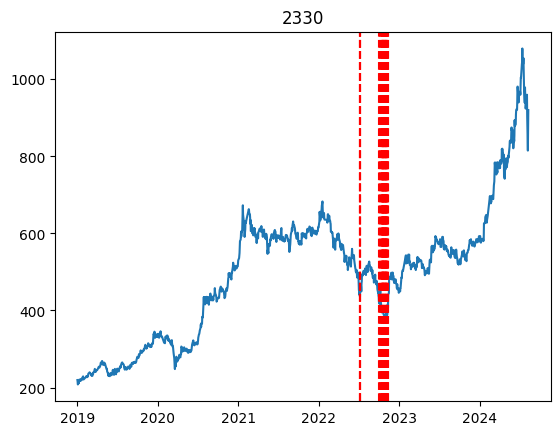

In [188]:
 import warnings
warnings.filterwarnings('ignore')
cl_2330

code,2330,signal
date,,
2019-01-02,219.5,None
2019-01-03,215.5,None
2019-01-04,208.0,None
2019-01-07,213.0,None
2019-01-08,211.0,None
...,...,...
2024-08-01,960.0,None
2024-08-02,903.0,None
2024-08-05,815.0,None
